This is the code for generating the density information.

In [1]:
import os
from astropy.table import Table
import pickle
import numpy as np

%pylab inline

from matplotlib.colors import LogNorm

import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
file_dir='./temp/ill_test/' #directory where files for corr_pc will be placed. I recommend using full path rather than relative path as here.
file_name='ill_test_kappa'  #prefix to be appended to the files being saved. Should be different for different datasets.

os.makedirs(file_dir,exist_ok=True)

# from within corr_pc directory, you can run corr_pc as 
# ./corr_pc file_dir/file_name.inp
# For example:
# ./corr_pc ./temp/ill_test/ill_test_Fappa.inp

In [3]:
ill_dir='/hildafs/datasets/IllustrisTNG/TNG100-1/' #path to the illustris data

In [4]:
S_dat_name='TNG100-1_99_galaxy_component_shapes_3I_subfind_mass-cut9' #filenames within illustris from which to read data
D_dat_name='TNG100-1_99_galaxy_component_shapes_3I_subfind_mass-cut9'

In [5]:
#read in shape sample
fname=ill_dir+S_dat_name+'.p'
with open(fname, "rb") as input_file:
    S_dat =pickle.load(input_file)
S_dat=Table(S_dat) #astropy table format, see to add new columns

In [6]:
#define x,y,z columns for cordinates. We will use the names x,y,z, below, instead of gal_pos_x etc. Different versions of the catalog have different naming conventions, please check.
# We will also use units of Mpc instead of Kpc, hence division by 1000
S_dat['x']=float64(S_dat['gal_pos_x']/1000)
S_dat['y']=float64(S_dat['gal_pos_y']/1000)
S_dat['z']=float64(S_dat['gal_pos_z']/1000)

# Tidal field from projected density field

In [7]:
nbins=1000 #this determines the grid resolution. resolution per side = 75/nbins in mpc/h.
be=np.linspace(0,75,nbins+1)
bc=0.5*(be[1:]+be[:-1])

In [8]:
galaxy_counts,ye,xe=np.histogram2d(S_dat['x'],S_dat['y'],bins=(be,be))

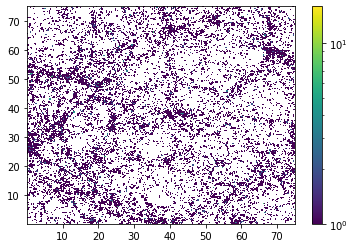

In [9]:
pcolor(bc,bc,galaxy_counts.T,norm=LogNorm())
colorbar()

In [10]:
k=np.fft.fftfreq(nbins, d=be[1]-be[0]) #fourier modes
k2=(k[:,None]**2+k[None,:]**2) #square of fourier modes

In [11]:
delta_R=galaxy_counts/galaxy_counts.mean()-1 #real space density field
delta_F=np.fft.fft2(delta_R)#fourier space density field

In [12]:
#apply gaussian smoothing kernel
smooth_r=1.0 #This was the original value CMS
smooth_r=0.5 #smoothing scale, in mpc/h
smooth_F=2*np.pi/smooth_r

smooth_filter=np.exp(-k2/(2*smooth_F**2))

delta_smooth_F=delta_F*smooth_filter
delta_smooth_R=np.fft.ifft2(delta_smooth_F)

In [13]:
potential_smooth_F=delta_smooth_F/k2#fourier space potential

tidal1_F=delta_smooth_F*(k[:,None]**2-k[None,:]**2)/k2 #fourier space tidal field
tidal2_F=delta_smooth_F*(k[:,None]*k[None,:])/k2

tidal1_F[np.where(k2==0)]=0 #correct for divide by 0
tidal2_F[np.where(k2==0)]=0
potential_smooth_F[np.where(k2.T==0)]=0

<ipython-input-13-afed6a9f5cf7>:1: RuntimeWarning: divide by zero encountered in true_divide
  potential_smooth_F=delta_smooth_F/k2#fourier space potential
<ipython-input-13-afed6a9f5cf7>:1: RuntimeWarning: invalid value encountered in true_divide
  potential_smooth_F=delta_smooth_F/k2#fourier space potential
<ipython-input-13-afed6a9f5cf7>:3: RuntimeWarning: invalid value encountered in true_divide
  tidal1_F=delta_smooth_F*(k[:,None]**2-k[None,:]**2)/k2 #fourier space tidal field
<ipython-input-13-afed6a9f5cf7>:4: RuntimeWarning: invalid value encountered in true_divide
  tidal2_F=delta_smooth_F*(k[:,None]*k[None,:])/k2


In [14]:
tidal1_R=np.fft.ifft2(tidal1_F) # real space tidal field
tidal2_R=np.fft.ifft2(tidal2_F)
potential_smooth_R=np.fft.ifft2(potential_smooth_F)


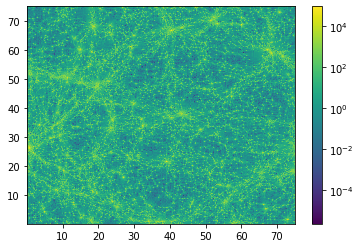

In [15]:
#sanity check
pcolor(bc,bc,np.real(tidal1_R**2+4*tidal2_R**2).T,norm=LogNorm())
colorbar()

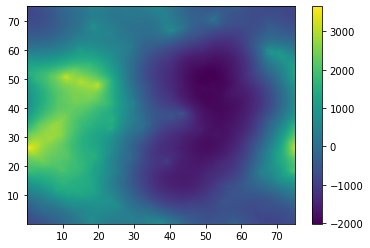

In [16]:
# potential. 
pcolor(bc,bc,np.real(potential_smooth_R).T)
colorbar()

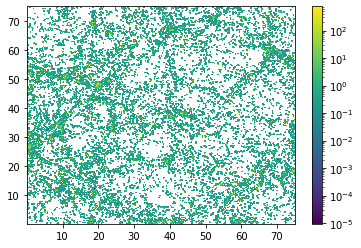

In [17]:
#smoothened density field
pcolor(bc,bc,np.real(delta_smooth_R).T,norm=LogNorm())
colorbar()

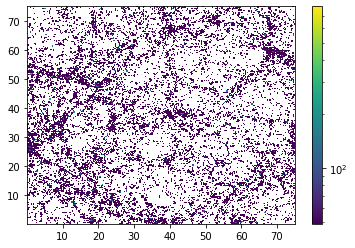

In [18]:
#un-smoothened density field. compare with above
pcolor(bc,bc,np.real(delta_R).T,norm=LogNorm())
colorbar()

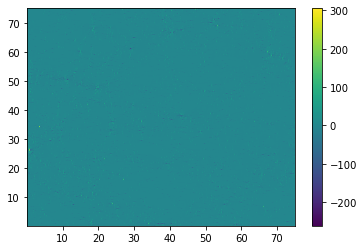

In [19]:
pcolor(bc,bc,np.real(tidal1_R).T)#,norm=LogNorm())
colorbar()

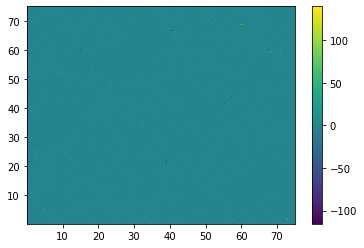

In [20]:
pcolor(bc,bc,np.real(tidal2_R).T)#,norm=LogNorm())
colorbar()

In [21]:
#find indices of grid cells to which galaxies belong
bi={}
for coor in ['x','y']:
    bi[coor]=np.digitize(S_dat[coor],bins=be)-1

In [22]:
#assign 2d density field to galaxies.
galaxies_delta_smooth_R=delta_smooth_R[bi['x'],bi['y']]

#assign 2d tidal field to galaxies.
galaxies_tidal1_R=tidal1_R[bi['x'],bi['y']]
galaxies_tidal2_R=tidal2_R[bi['x'],bi['y']]

In [23]:
print(max(abs(np.imag(galaxies_delta_smooth_R))))

print(max(abs(np.imag(galaxies_tidal1_R))))

print(max(abs(np.imag(galaxies_tidal2_R))))

5.943662232252742e-14
2.767126536626279e-14
0.5562381390675871


In [24]:
densinfo = pd.DataFrame(
    {
        'delta_smooth_R':np.real(galaxies_delta_smooth_R),
        'tidal1_R':np.real(galaxies_tidal1_R),
        'tidal2_R':np.real(galaxies_tidal2_R)
    }
)

densinfo

,delta_smooth_R,tidal1_R,tidal2_R
0,534.120233,103.608742,34.019348
1,137.348748,-30.544907,17.402045
2,231.582259,51.964704,-11.620513
3,92.407333,-56.798864,0.932820
4,145.211156,26.321327,30.984719
...,...,...,...
20046,44.623580,5.718081,0.116605
20047,44.394287,-2.693726,1.330215
20048,44.432667,5.292025,0.534760
20049,44.531074,-5.379707,-5.492828


In [25]:
pickle.dump(densinfo, open('galdens.p', 'wb'))

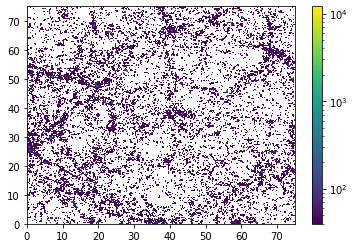

In [26]:
_=hist2d(S_dat['x'],S_dat['y'],bins=(be,be),weights=np.real(galaxies_delta_smooth_R),norm=LogNorm())
colorbar()

#  Tidal field from 3d density field

In [27]:
nbins=750#//2 #this determines the grid resolution. resolution per side = 75/nbins in mpc/h.
be=np.linspace(0,75,nbins+1)
bc=0.5*(be[1:]+be[:-1])

In [28]:
galaxy_counts3d,be3=np.histogramdd(np.array([S_dat['x'],S_dat['y'],S_dat['z']]).T,bins=[be,be,be])

In [29]:
k=np.fft.fftfreq(nbins, d=be[1]-be[0]) #fourier modes
k2=(k[:,None,None]**2+k[None,:,None]**2+k[None,None,:]**2) #square of fourier modes

In [30]:
galaxy_counts3d,galaxy_counts3d.mean()

(array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],


In [31]:
delta3d_R=galaxy_counts3d/galaxy_counts3d.mean()-1 #real space density field
delta3d_F=np.fft.fftn(delta3d_R)#fourier space density field

In [32]:
#find indices of grid cells to which galaxies belong
bi={}
for coor in ['x','y','z']:
    bi[coor]=np.digitize(S_dat[coor],bins=be)-1

In [33]:
#apply gaussian smoothing kernel

#smoothing scale, in mpc/h

smooth_r_list = [0.1,0.5,1.0,2.0,5.0]

In [34]:
for smooth_r in smooth_r_list:
    
    print(smooth_r)
    
    smooth_k=2*np.pi/smooth_r

    smooth_filter=np.exp(-k2/(2*smooth_k**2))

    delta3d_smooth_F=delta3d_F*smooth_filter
    delta3d_smooth_R=np.fft.ifftn(delta3d_smooth_F)

#    potential3d_smooth_F=delta3d_smooth_F/k2

#    tidal1_3d_F=delta3d_smooth_F*(k[:,None,None]**2-k[None,:,None]**2)/k2
#    tidal2_3d_F=delta3d_smooth_F*(k[:,None,None]*k[None,:,None])/k2

#    tidal1_3d_F[np.where(k2==0)]=0
#    tidal2_3d_F[np.where(k2==0)]=0
#    potential3d_smooth_F[np.where(k2.T==0)]=0

#    tidal1_3d_R=np.fft.ifftn(tidal1_3d_F)
#    tidal2_3d_R=np.fft.ifftn(tidal2_3d_F)
#    potential3d_smooth_R=np.fft.ifft2(potential3d_smooth_F)


#assign 3d density to galaxies.
    galaxies_delta3d_smooth_R=delta3d_smooth_R[bi['x'],bi['y'],bi['z']]

#assign 3d tidal field to galaxies.
#    galaxies_tidal1_3d_R=tidal1_3d_R[bi['x'],bi['y'],bi['z']]
#    galaxies_tidal2_3d_R=tidal2_3d_R[bi['x'],bi['y'],bi['z']]

    varname = 'delta3d_smooth_real_'+str(smooth_r)
    densinfo[varname] = np.real(galaxies_delta3d_smooth_R)

0.1
0.5
1.0
2.0
5.0


In [35]:
densinfo

,delta_smooth_R,tidal1_R,tidal2_R,delta3d_smooth_real_0.1,delta3d_smooth_real_0.5,delta3d_smooth_real_1.0,delta3d_smooth_real_2.0,delta3d_smooth_real_5.0
0,534.120233,103.608742,34.019348,230934.506008,219286.807747,188165.724574,113919.289052,24561.025791
1,137.348748,-30.544907,17.402045,41969.795545,39467.520520,32960.492219,18635.817583,4106.676554
2,231.582259,51.964704,-11.620513,83930.157692,78676.965545,64928.938160,34360.274491,5483.827682
3,92.407333,-56.798864,0.932820,20986.065251,19763.752550,16496.479218,8826.505502,1533.237698
4,145.211156,26.321327,30.984719,41959.573446,39217.227087,32032.342110,16078.863625,1795.404181
...,...,...,...,...,...,...,...,...
20046,44.623580,5.718081,0.116605,20972.611910,19453.996501,15530.991053,7208.367760,656.605502
20047,44.394287,-2.693726,1.330215,20972.611907,19453.990603,15530.785166,7205.983490,656.440324
20048,44.432667,5.292025,0.534760,20972.611904,19453.989981,15530.815377,7206.349755,656.482578
20049,44.531074,-5.379707,-5.492828,20972.611919,19453.996790,15530.841036,7206.080015,656.443107


In [36]:
pickle.dump(densinfo, open('galdens.p', 'wb'))